# Realistic Mass and Velocity

With the key components of the aerosol model in place, we can now start to build towards more realistic aerosol particles. This notebook will focus on the mass and velocity of the particles. This involves imporvements, the initial conditions, and the forces acting on the particles.


In [9]:
# Code Section: Importing Necessary Libraries and Initializing Variables
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from particula.lagrangian import boundary, integration, collisions, particle_property, particle_pairs
from particula.activity import machine_limit
# Initializing the Torch Generator and setting the data type
seed = 1234
torch.manual_seed(seed)  # Set the seed for reproducibility
t_type = torch.float32

## Initialization

Here we will change the initialalization of the particles to be more realistic. We will use a normal distribution for the particle masses. For the velocities, we will use the particle's thermal velocity (induced from Brownian motion). The initial positions will be randomly distributed in a box.

In [10]:
# Setting up the Simulation Parameters and Initial Conditions
# Define fixed parameters
TOTAL_NUMBER_OF_PARTICLES = 1000
TIME_STEP = 0.001
SIMULATION_TIME = 100
CUBE_SIDE = 0.100  # meters
save_points = 50

# new parameters
density_uniform = 1.5e3
mean_radius_nm = 100
std_dev_nm = 20
system_temperature_kelvin = 300
system_pressure_pascal = 1e5


# generate particle masses
mass = particle_property.generate_particle_masses(
    mean_radius=mean_radius_nm,
    std_dev_radius=std_dev_nm,
    density=density_uniform,
    num_particles=TOTAL_NUMBER_OF_PARTICLES,
    radius_input_units="nm",
)

# Initialize particle velocities randomly
velocity = particle_property.random_thermal_velocity(
    temperature_kelvin=system_temperature_kelvin,
    mass_kg=mass,
    number_of_particles=TOTAL_NUMBER_OF_PARTICLES,
    t_type=t_type,
    random_seed=seed
)

# Set constant mass and density for all particles
density = torch.ones(TOTAL_NUMBER_OF_PARTICLES, dtype=t_type) * density_uniform

#---------------Same as before------------------#
# Initialize particle positions randomly within the cube
position = torch.rand(
    3,
    TOTAL_NUMBER_OF_PARTICLES,
    dtype=t_type) * CUBE_SIDE - CUBE_SIDE / 2

# Initialize force as zero for all particles
force = torch.zeros(3, TOTAL_NUMBER_OF_PARTICLES, dtype=t_type)

# Generate indices for particles, could be integer type
indices = torch.arange(TOTAL_NUMBER_OF_PARTICLES, dtype=t_type)  # could be int

# Calculate the total number of iterations for the simulation
total_iterations = int(SIMULATION_TIME / TIME_STEP)

# Initialize a tensor to track the total mass over iterations
total_mass = torch.zeros(total_iterations, dtype=t_type)

# Define gravity acting on all particles
gravity = torch.tensor(
    [0, 0, -9.81]).repeat(TOTAL_NUMBER_OF_PARTICLES, 1).transpose(0, 1)

# Initializing Arrays for Saving Position and Mass Data
# Create arrays to store position and mass data at each save point
save_position = np.zeros((3, TOTAL_NUMBER_OF_PARTICLES, save_points))
save_mass = np.zeros((TOTAL_NUMBER_OF_PARTICLES, save_points))

# Determine which iterations will correspond to the save points
save_iterations = np.linspace(0, total_iterations, save_points, dtype=int)
radius = particle_property.radius_calculation(mass=mass, density=density)

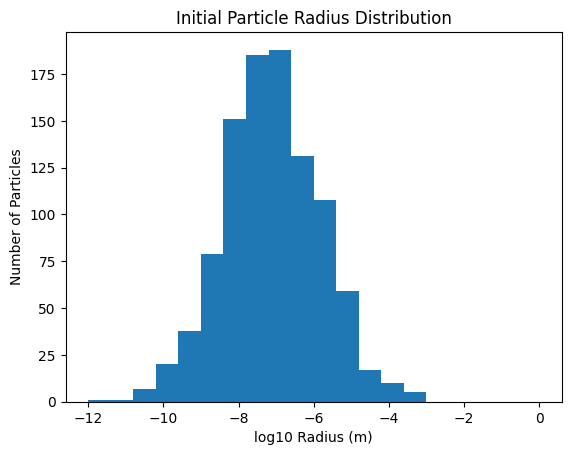

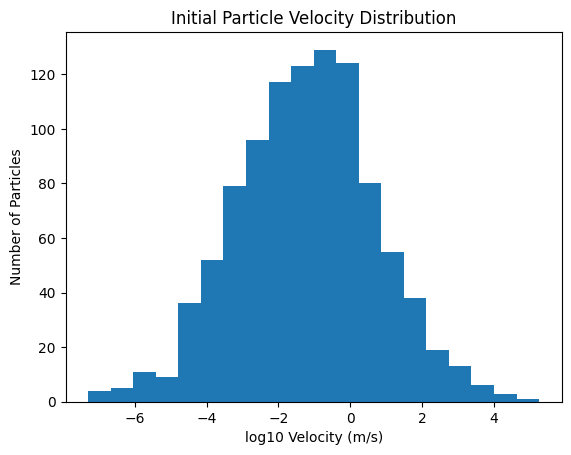

In [11]:
# plot initial radius distribution
fig, ax = plt.subplots()
ax.hist(machine_limit.safe_log10(radius), bins=20, range=(-12,0))
ax.set_xlabel("log10 Radius (m)")
ax.set_ylabel("Number of Particles")
ax.set_title("Initial Particle Radius Distribution")
plt.show()

# plot initial velocity distribution
fig, ax = plt.subplots()
ax.hist(machine_limit.safe_log10(particle_property.speed(velocity)), bins=20 )
ax.set_xlabel("log10 Velocity (m/s)")
ax.set_ylabel("Number of Particles")
ax.set_title("Initial Particle Velocity Distribution")
plt.show()

In [12]:
# Initialize counter for saving data
save_counter = 0
start_time = time.time()

for i in range(total_iterations):

    # NEW calculate sweep and prune collision pairs
    radius = particle_property.radius_calculation(mass=mass, density=density)
    valid_collision_indices_pairs = particle_pairs.full_sweep_and_prune(
         position=position, radius=radius)

    if valid_collision_indices_pairs.shape[0] > 0:
        # Coalesce particles that have collided and update their velocity and mass
        velocity, mass = collisions.coalescence(
            position=position,
            velocity=velocity,
            mass=mass,
            radius=radius,
            collision_indices_pairs=valid_collision_indices_pairs)

    # # NEW: fiction factor
    # friction_factor = particle_property.friction_factor_wrapper(
    #     radius_meter=radius,
    #     temperature_kelvin=system_temperature_kelvin,
    #     pressure_pascal=system_pressure_pascal,
    # )
    # Calculate the force acting on the particles (e.g., gravity)
    # NEW: friction factor is opposite direction of velocity
    force = mass * gravity - velocity * 0.001 #friction_factor

    # Integrate the equations of motion to update position and velocity
    position, velocity = integration.leapfrog(
        position=position, velocity=velocity, force=force, mass=mass, time_step=TIME_STEP)

    # Apply boundary conditions for the cube (wrap-around)
    position = boundary.wrapped_cube(position=position, cube_side=CUBE_SIDE)

    # Save the position and mass data at designated save points
    if i == save_iterations[save_counter]:
        save_position[:, :, save_counter] = position.detach().numpy()
        save_mass[:, save_counter] = mass.detach().numpy()
        save_counter += 1

# Perform a final save of the position and mass data
save_position[:, :, -1] = position.detach().numpy()
save_mass[:, -1] = mass.detach().numpy()

# Calculate the total simulation time
end_time = time.time()
print(f"Total wall time: {end_time - start_time} seconds")
print(f"Ratio of wall time to simulation time: {(end_time - start_time) / SIMULATION_TIME}")

Total wall time: 50.934478998184204 seconds
Ratio of wall time to simulation time: 0.5093447899818421


## Plot Positions

Compared to the previous notebook, the sweep and prune is about 2x faster for this scenario. The exact speedup depends on the number of particles and the distribution of particles in space.

Number of particles at the end: 556


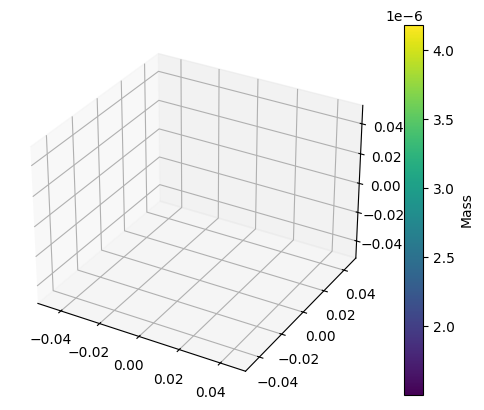

In [20]:
# Processing the Final Data for Visualization

# Select the final time index for the data
time_index = -1
position_final = save_position[:, :, time_index]
mass_final = save_mass[:, time_index]

# Filter out particles with zero mass
filter_zero_mass = mass_final > 0

# Calculate the radius and area of each particle
radius_final = particle_property.radius_calculation(mass=mass_final, density=density)
particle_area = np.pi * radius_final**2

# Display the number of remaining particles
print(f"Number of particles at the end: {filter_zero_mass.sum()}")

# Creating a 3D Plot for Visualization
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Choose a color map for the scatter plot
cmap = plt.cm.viridis

# Plot the final positions of particles with non-zero mass
scatter_plot = ax.scatter(
    position_final[0, filter_zero_mass],
    position_final[1, filter_zero_mass],
    position_final[2, filter_zero_mass],
    c=mass_final[filter_zero_mass],
    cmap=cmap,
    s=particle_area[filter_zero_mass]  # Particle size based on area
)

# Set axis limits based on cube dimensions
ax.set_xlim(-CUBE_SIDE / 2, CUBE_SIDE / 2)
ax.set_ylim(-CUBE_SIDE / 2, CUBE_SIDE / 2)
ax.set_zlim(-CUBE_SIDE / 2, CUBE_SIDE / 2)

# Add a color bar indicating particle mass
color_bar = plt.colorbar(scatter_plot, ax=ax)
color_bar.set_label('Mass')

# Show the plot with optimized layout
plt.show()
fig.tight_layout()

 ## Analyzing the Mass Distribution of Particles

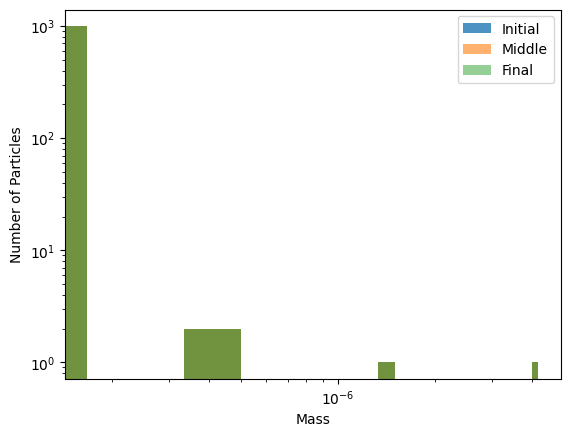

In [8]:
# Visualizing the Mass Distribution at Different Stages

# Create a new figure for the histogram
fig = plt.figure()
ax = fig.add_subplot()
max_mass = np.max(save_mass[:, -1])
# Plot histograms of mass distribution at different stages
ax.hist(save_mass[:, 0], bins=25,
        alpha=0.8, label='Initial', range=(0, max_mass))
ax.hist(save_mass[:, 24], bins=25,
        alpha=0.6, label='Middle', range=(0, max_mass))
ax.hist(save_mass[:, -1], bins=25,
        alpha=0.5, label='Final', range=(0, max_mass))

# Setting labels and title for the plot
ax.set_xlabel('Mass')
ax.set_ylabel('Number of Particles')
ax.set_xscale('log')
ax.set_yscale('log')
# Add a legend to the plot
ax.legend()

# Display the plot
plt.show()

# Adjust layout for optimal visualization
fig.tight_layout()

## Summary of Smaller Particles